In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader

from torchvision.datasets import ImageFolder
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
device

device(type='cuda', index=0)

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
])

batch_size = 128

train_dataset = ImageFolder("./animefacedataset/", transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)

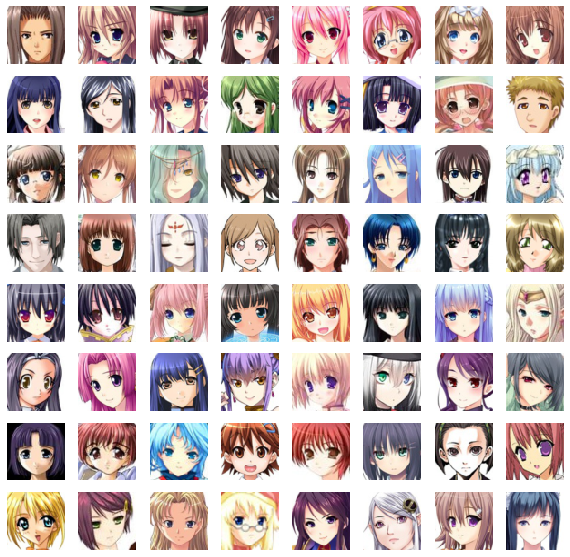

In [4]:
def show_images(images):
    plt.figure(figsize=(10, 10))
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.axis("off")
        img = np.moveaxis(np.array(images[i].to("cpu")), 0, 2)
        plt.imshow((img+1)/2)

show_images(next(iter(train_loader))[0])

In [5]:
discriminator = nn.Sequential(
    # in: 3x64x64
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=64),
    nn.LeakyReLU(negative_slope=0.2),  # 64x32x32

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.LeakyReLU(negative_slope=0.2),  # 128x16x16

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.LeakyReLU(negative_slope=0.2),  # 256x8x8

    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.LeakyReLU(negative_slope=0.2),  # 512x4x4
    
    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, bias=False),  # 1x1x1
    nn.Flatten(),  # 1
    nn.Sigmoid()
)

generator = nn.Sequential(
    # in: 128x1x1- 128 dimensional "Latent" vector
    nn.ConvTranspose2d(in_channels=128, out_channels=512, kernel_size=4, bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.ReLU(),  # 512x4x4

    nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.ReLU(),  # 256x8x8
    
    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(),  # 128x16x16
    
    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(),  # 64x32x32
    
    nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # 3x64x64
)

In [6]:
def discriminator_step(real_images, discriminator, d_optimizer, generator, g_optimizer):

    loss_function = nn.BCELoss()

    # Real images, should predict "real"/1
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.shape[0], 1, device=device)
    real_loss = loss_function(real_preds, real_targets)
    
    # Fake images should not fool the discriminator, should predict "fake"/0
    random_latents = torch.randn(real_images.shape[0], 128, 1, 1, device=device)
    fake_images = generator(random_latents)
    
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.shape[0], 1, device=device)
    fake_loss = loss_function(fake_preds, fake_targets)
    
    d_loss = real_loss + fake_loss
    d_loss.backward()  # Will compute gradients wrt ALL params
    d_optimizer.step()  # We only update discriminator params
    
    # Clear ALL gradients computed by backward()
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    
    with torch.no_grad():
        real_acc = torch.sum(torch.round(real_preds)==1)/real_images.shape[0]
        fake_acc = torch.sum(torch.round(fake_preds)==0)/fake_images.shape[0] 

    return d_loss.item(), real_acc.item(), fake_acc.item()


def generator_step(generator, g_optimizer, discriminator, d_optimizer):

    loss_function = nn.BCELoss()
    
    random_latents = torch.randn(batch_size, 128, 1, 1, device=device)
    fake_images = generator(random_latents)
    
    # Fake images SHOULD fool the discriminator, it should predict "real"/1
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    
    g_loss = loss_function(preds, targets)
    g_loss.backward()  # Will compute gradients wrt ALL params
    g_optimizer.step()  # We only update generator params
    
    # Clear ALL gradients computed by backward()
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()
    
    return g_loss.item()

In [8]:
discriminator = discriminator.to(device)
generator = generator.to(device)

In [21]:
fixed_latents = torch.randn(batch_size, 128, 1, 1).to(device)

def check_generated_images(generator, latents=fixed_latents):
    generator.eval()
    with torch.no_grad():
        fake_images = generator(latents)
        show_images(fake_images)

In [10]:
def train(discriminator, generator, train_loader, alpha, num_epochs):

    d_optimizer = Adam(discriminator.parameters(), lr=alpha, betas=(0.5, 0.999))
    g_optimizer = Adam(generator.parameters(), lr=alpha, betas=(0.5, 0.999))
    
    for e in range(num_epochs):
        discriminator.train()
        generator.train()
        
        batch_d_losses = []
        batch_d_real_accs = []
        batch_d_fake_accs = []
        batch_g_losses = []
      
        for real_images, _ in tqdm(train_loader):
            real_images = real_images.to(device)
            
            # Perform the 2 training steps in succession
            a, b, c = discriminator_step(real_images, discriminator, d_optimizer, generator, g_optimizer)
            d = generator_step(generator, g_optimizer, discriminator, d_optimizer)
            
            batch_d_losses.append(a)
            batch_d_real_accs.append(b)
            batch_d_fake_accs.append(c)
            batch_g_losses.append(d)
        
        epoch_d_loss = np.mean(batch_d_losses)
        epoch_d_real_acc = np.mean(batch_d_real_accs)
        epoch_d_fake_acc = np.mean(batch_d_fake_accs)
        epoch_g_loss = np.mean(batch_g_losses)
        
        print(f"Epoch: {e+1}, G Loss: {epoch_g_loss}, D Loss: {epoch_d_loss}, D Acc for Reals: {epoch_d_real_acc}, D Acc for Fakes: {epoch_d_fake_acc}")

        if (e+1)%5 == 0 or e == 0:
            check_generated_images(generator)
            plt.show()

100%|██████████| 497/497 [01:34<00:00,  5.25it/s]


Epoch: 1, G Loss: 4.9836837585783105, D Loss: 0.7355556211263781, D Acc for Reals: 0.8390762594863922, D Acc for Fakes: 0.8418485752533619


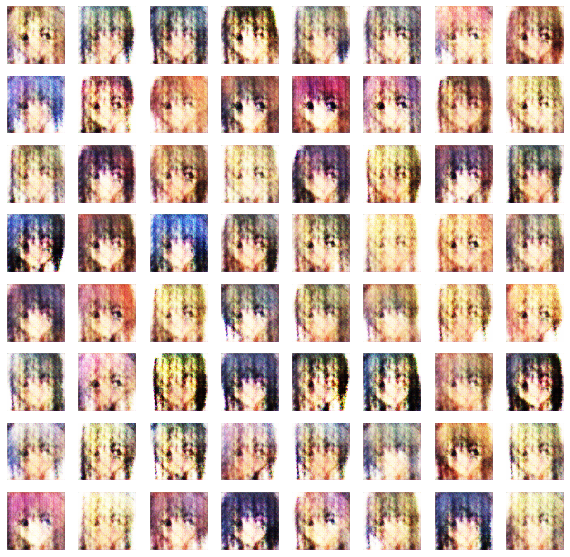

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 2, G Loss: 5.014960679249985, D Loss: 0.6699666270247887, D Acc for Reals: 0.846228752337711, D Acc for Fakes: 0.8580756045922907


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 3, G Loss: 5.2186536733773154, D Loss: 0.5699752872618631, D Acc for Reals: 0.8760923903952662, D Acc for Fakes: 0.8906407193158954


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 4, G Loss: 5.675946384368528, D Loss: 0.445869816920647, D Acc for Reals: 0.9102692452954574, D Acc for Fakes: 0.9293784214936991


100%|██████████| 497/497 [01:35<00:00,  5.18it/s]


Epoch: 5, G Loss: 6.036342432021615, D Loss: 0.3935383665684603, D Acc for Reals: 0.9215816408095945, D Acc for Fakes: 0.9430174798792756


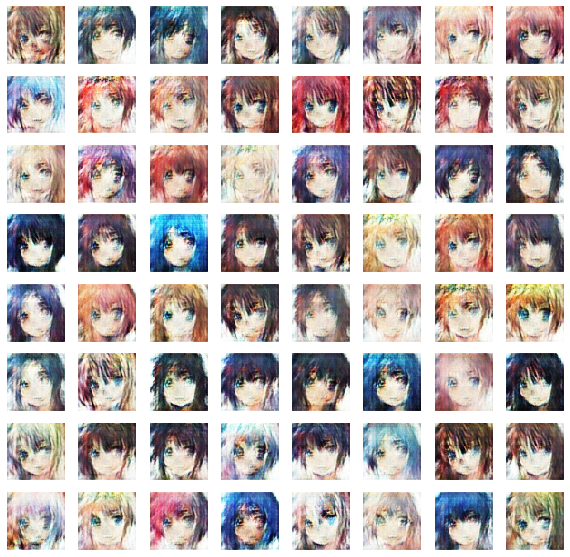

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 6, G Loss: 6.148351947546485, D Loss: 0.33525978453022615, D Acc for Reals: 0.9364259828264325, D Acc for Fakes: 0.9549327213279678


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 7, G Loss: 6.097855286099302, D Loss: 0.3396321667407, D Acc for Reals: 0.9361009808853119, D Acc for Fakes: 0.9510657696177063


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 8, G Loss: 6.355116773659075, D Loss: 0.2956253677396707, D Acc for Reals: 0.9424726116345442, D Acc for Fakes: 0.9578728458771044


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 9, G Loss: 6.48888850020211, D Loss: 0.2791531785865365, D Acc for Reals: 0.946915870221328, D Acc for Fakes: 0.9628080985915493


100%|██████████| 497/497 [01:38<00:00,  5.04it/s]


Epoch: 10, G Loss: 6.378306283797297, D Loss: 0.24996335453108343, D Acc for Reals: 0.9573220573440644, D Acc for Fakes: 0.9703431628359636


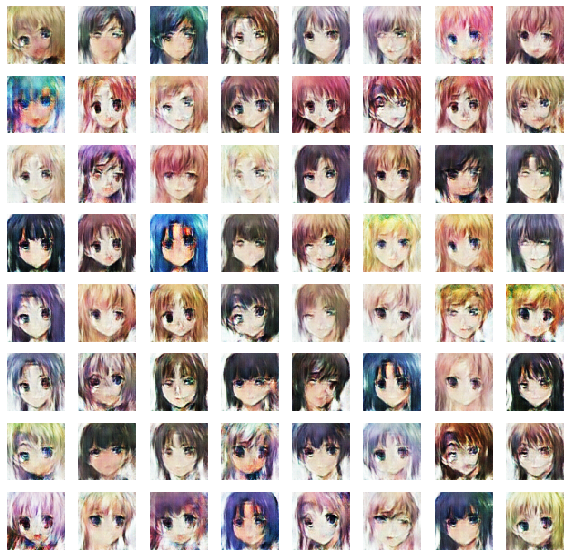

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 11, G Loss: 6.123532181534489, D Loss: 0.28452473308261433, D Acc for Reals: 0.9536647645520492, D Acc for Fakes: 0.9636255030181087


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 12, G Loss: 6.319514552112556, D Loss: 0.2756552561626618, D Acc for Reals: 0.9542882293762576, D Acc for Fakes: 0.9647311629423913


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 13, G Loss: 5.915888702125856, D Loss: 0.27725628265029784, D Acc for Reals: 0.9520877292698298, D Acc for Fakes: 0.9645372233400402


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 14, G Loss: 6.052494045954115, D Loss: 0.22408501712429213, D Acc for Reals: 0.9643853379926931, D Acc for Fakes: 0.9741731639839034


100%|██████████| 497/497 [01:35<00:00,  5.20it/s]


Epoch: 15, G Loss: 5.836467070838575, D Loss: 0.29073324455304345, D Acc for Reals: 0.9478959797373719, D Acc for Fakes: 0.9577779175050302


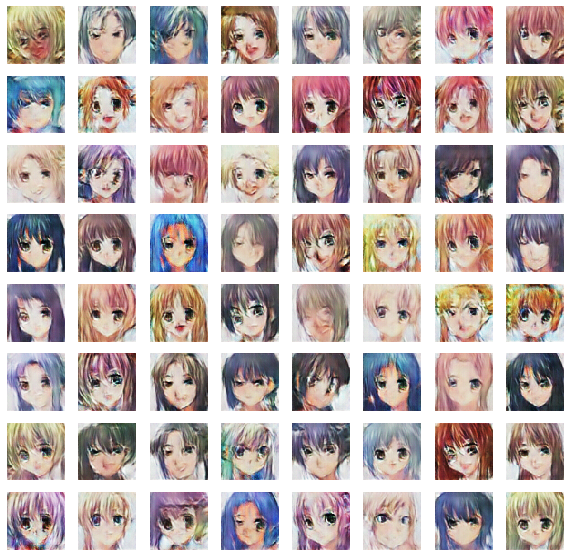

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 16, G Loss: 5.55873900100259, D Loss: 0.22223677977889597, D Acc for Reals: 0.9656428832643229, D Acc for Fakes: 0.9746447434607646


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 17, G Loss: 5.536919113930682, D Loss: 0.30799465252075275, D Acc for Reals: 0.9509004106224183, D Acc for Fakes: 0.959758551307847


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 18, G Loss: 5.29362289487596, D Loss: 0.24482582866680813, D Acc for Reals: 0.9624520662564867, D Acc for Fakes: 0.9698817907444668


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 19, G Loss: 5.264475591510714, D Loss: 0.2623630606717387, D Acc for Reals: 0.962713782696177, D Acc for Fakes: 0.9678539989939637


100%|██████████| 497/497 [01:35<00:00,  5.20it/s]


Epoch: 20, G Loss: 5.323624179037044, D Loss: 0.31234298854076886, D Acc for Reals: 0.95207180583501, D Acc for Fakes: 0.9576207243460765


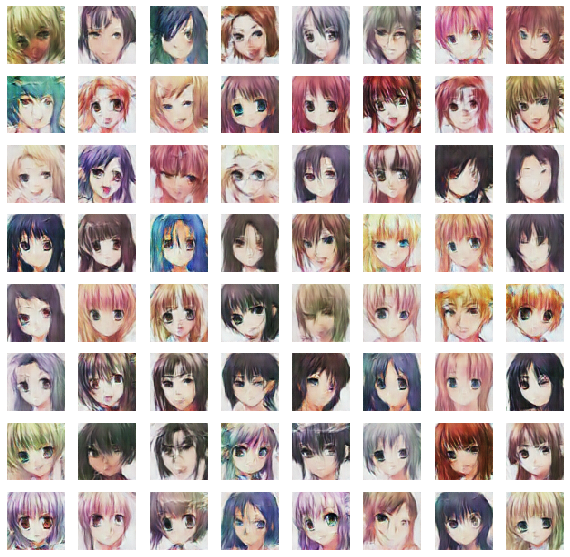

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 21, G Loss: 5.066020661316647, D Loss: 0.23067673988325496, D Acc for Reals: 0.9664813148183842, D Acc for Fakes: 0.9709192655935613


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 22, G Loss: 5.137848861980246, D Loss: 0.28559277811175743, D Acc for Reals: 0.955404300804829, D Acc for Fakes: 0.9596591317197927


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 23, G Loss: 4.844158100620122, D Loss: 0.28809141674991584, D Acc for Reals: 0.9590669014084507, D Acc for Fakes: 0.9637251267250875


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch: 24, G Loss: 4.809342662753234, D Loss: 0.2765410256232894, D Acc for Reals: 0.9601370397228111, D Acc for Fakes: 0.9650245221327968


100%|██████████| 497/497 [01:36<00:00,  5.17it/s]


Epoch: 25, G Loss: 4.891086765275462, D Loss: 0.27993446456594484, D Acc for Reals: 0.9590511820925554, D Acc for Fakes: 0.9628552565392354


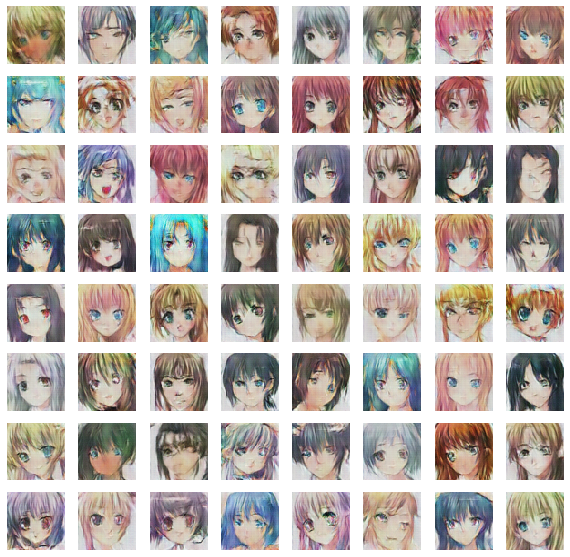

CPU times: user 40min 41s, sys: 18.4 s, total: 41min
Wall time: 40min 27s


In [11]:
%%time

train(discriminator, generator, train_loader, alpha=2e-4, num_epochs=25)

In [32]:
torch.save(discriminator.state_dict(), "./D.pth")
torch.save(generator.state_dict(), "./G.pth")

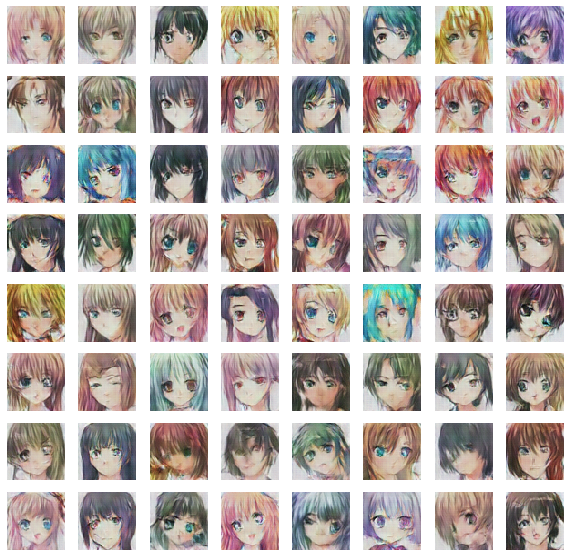

In [33]:
# Run to generate

check_generated_images(generator, latents=torch.randn(batch_size, 128, 1, 1).to(device))